In [ ]:
%matplotlib inline 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vgg = list(torchvision.models.vgg19(pretrained=True).features[:-1].children())
vgg = nn.Sequential(*[nn.AvgPool2d(2) if isinstance(n, nn.MaxPool2d) else n for n in vgg]).to(dev)
#vgg = nn.Sequential(*vgg).to(dev)
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval();

In [ ]:
# All conv layers. Added +1 for incorporating ReLU
layer_ids = np.array([int(idx) for idx, m in vgg.named_children() if isinstance(m, nn.Conv2d)])
len(layer_ids)

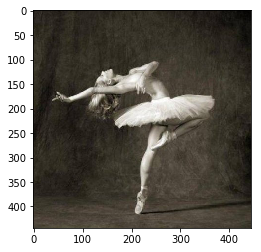

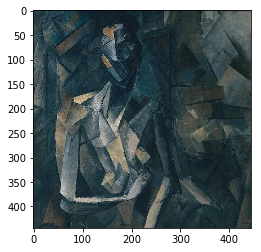

In [146]:
p = Image.open('dancing.jpg')

a = Image.open('picasso.jpg')
a = a.resize(p.size)

plt.imshow(p)
plt.show()

plt.imshow(a)
plt.show()

In [147]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

tnorm = transforms.Compose([
    transforms.ToTensor(), # 0..1
    transforms.Normalize(mean=mean, std=std)    
])

class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
class Clip:
    def __call__(self, tensor):
        return torch.clamp(tensor, min=0., max=1.)
    
class ToNumpy():
    def __call__(self, tensor):
        t = np.transpose(tensor.detach().numpy(), (1, 2, 0))
        t *= 255.
        return t.astype(np.uint8)
        
tdenorm = transforms.Compose([
    Denormalize(mean=mean, std=std),
    Clip(),
    ToNumpy()    
])

In [148]:
from tqdm import tqdm

class ContentLoss:
    
    def __init__(self, net, layer_id):
        self.layer_id = layer_id
        self.hook = net[layer_id].register_forward_hook(self.hookfn)        
        
    def init(self):
        # assumes net(p) called
        self.ref = self.act.clone()
        
    def hookfn(self, n, inp, outp):
        self.act = outp
        
    def remove(self):
        self.hook.remove()

    def __call__(self):
        # assumes net(x) called
        return F.mse_loss(self.act, self.ref)
        
    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        self.remove()

class StyleLoss:
    
    def __init__(self, net, layer_ids):
        self.layer_ids = layer_ids
        self.layers = [net[l] for l in layer_ids]
        self.hooks = [l.register_forward_hook(self.hookfn) for l in self.layers]
        self.prehook = net.register_forward_pre_hook(self.prehookfn)
        self.w = 1 / len(layer_ids)
        self.act = []
        
    def hookfn(self, n, inp, outp):
        self.act.append(outp)
        
    def prehookfn(self, n, inp):
        self.act = []

    def init(self):
        # assumes net(a) called        
        self.A = [self.gram(x).clone() for x in self.act]        
        
    def remove(self):
        self.prehook.remove()
        [h.remove() for h in self.hooks]
        
    def __call__(self):
        G = [self.gram(x) for x in self.act]
        E = torch.stack([F.mse_loss(g, a) for g,a in zip(G, self.A)])
        return E.mean()
    
    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        self.remove()
        
    def gram(self, x):
        c, n = x.shape[1], x.shape[2]*x.shape[3]
        f = x.view(c, n)
        return torch.mm(f, f.t()) / (c*n)
        

In [159]:
def max_lr(opt):
    return max([g['lr'] for g in opt.param_groups])    

def style_transfer(net, dev, p, a, content_layer_id, style_layer_ids, niter=200, lr=1e-2):  
    
    p = p.to(dev).unsqueeze(0)
    a = a.to(dev).unsqueeze(0)    
    #x = torch.tensor(torch.randn_like(p)*1e-1, requires_grad=True).to(dev)
    x = p.clone()
    x.requires_grad_()
    
    xmin = -mean / std
    xmax = (1-mean) / std
    
    opt = optim.Adam([x], lr=lr)
    scheduler = sched.ReduceLROnPlateau(opt, 'min', threshold_mode='abs', threshold=1e-3, patience=20, cooldown=50, min_lr=1e-3)
    
    #opt = optim.LBFGS([x])
    
    with ContentLoss(net, content_layer_id) as cl, StyleLoss(net, style_layer_ids) as sl:
        net(p); cl.init()
        net(a); sl.init()

        with tqdm(total=niter) as t: 
            for idx in range(niter):
                
                opt.zero_grad()
                x.data[:,0].clamp_(xmin[0], xmax[0])
                x.data[:,1].clamp_(xmin[1], xmax[1])
                x.data[:,2].clamp_(xmin[2], xmax[2])

                net(x)
                closs = cl()
                sloss = sl() * 1e+10
                loss = closs + sloss
                loss.backward()

                opt.step()
                
                t.set_postfix(loss=(closs.item(), sloss.item(), loss.item()), lr=max_lr(opt))
                t.update()
                
                scheduler.step(loss)
                

        return [x]

100%|████| 500/500 [00:36<00:00, 13.61it/s, loss=(0.5458983778953552, 10.016866683959961, 10.562765121459961), lr=0.01]


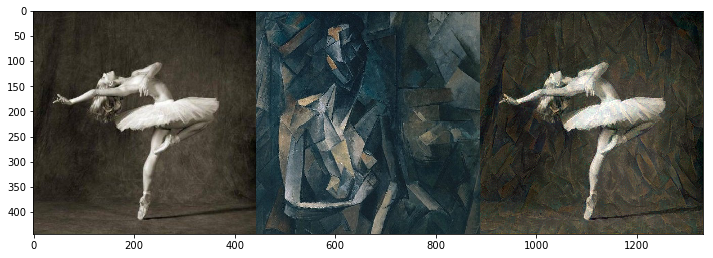

In [161]:
c_id = layer_ids[4]
s_ids = layer_ids[[5,6,7,8]]
images = style_transfer(vgg, dev, tnorm(p), tnorm(a), c_id, s_ids, niter=500, lr=1e-2);
images = [tdenorm(x.squeeze().cpu()) for x in images]

plt.figure(figsize=(12,6))
plt.imshow(np.hstack((p, a, images[-1])))
plt.savefig('style-final.png', dpi=600)
plt.show()